In [1]:
import sys, os, copy
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

# Project plumbing
project_root = "/Users/merlijnbroekers/Desktop/Drone_Interception"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH ok — cwd:", os.getcwd())
print("src/ exists?  ", os.path.exists(Path(project_root) / "src"))

from src.models.evaders.registry import build_evader
from src.models.pursuers.registry import build_pursuer
from scripts.analysis.utils.metrics_utils import compute_simulation_metrics


PYTHONPATH ok — cwd: /Users/merlijnbroekers/Desktop/Drone_Interception/scripts/analysis
src/ exists?   True


In [2]:
from scripts.analysis.utils.notebook_helpers import AnalysisRunConfig

RUN_CFG = AnalysisRunConfig(
    n_trials=1,
    evader_csv_dir=f"{project_root}/evader_datasets/top_10_csv",
    out_dir=f"{project_root}/figures/reward_smoothing",
)

# Toggles for run/load behavior
RUN_TOGGLE = {
    "RECOMPUTE": False,
    "SAVE_RESULTS": False,
}

out_dir = Path(RUN_CFG.out_dir); out_dir.mkdir(parents=True, exist_ok=True)
print(RUN_CFG)

output_dir = Path(RUN_CFG.out_dir)
output_dir.mkdir(parents=True, exist_ok=True)

AnalysisRunConfig(n_trials=1, evader_csv_dir='/Users/merlijnbroekers/Desktop/Drone_Interception/evader_datasets/top_10_csv', out_dir='/Users/merlijnbroekers/Desktop/Drone_Interception/figures/reward_smoothing', results_csv=None, reuse_seed_per_evader=None)


In [3]:
ABSTRACTIONS = {
    "motor": {
        "model": "motor",
        "action_dim": 4,
        "opt_feats": ["attitude_mat", "rates", "omega_norm"],
    },
    "ctbr": {
        "model": "ctbr",
        "action_dim": 4,
        "opt_feats": ["attitude_mat", "rates", "T_force"],
    },
}

def apply_abstraction_to_config(cfg: dict, abstraction: str) -> dict:
    """Mutate cfg in-place to match the abstraction (model + observation spec)."""
    meta = ABSTRACTIONS[abstraction]
    cfg["PURSUER"]["MODEL"] = meta["model"]
    cfg["OBSERVATIONS"]["ACTION_DIM"] = int(meta["action_dim"])
    cfg["OBSERVATIONS"]["OPTIONAL_FEATURES"] = list(meta["opt_feats"])
    return cfg

In [4]:
# NOTE THIS CONFIG HAS SLIGHTLY DIFFERENT PARAMETERS THAN DEFAULT. THEY CORRESPOND TO THE SYSTEM IDENTIFICATION 
# DONE FOR A DRONE WHICH LATER IN THE PROJECT CRASHED/BROKE. STILL BEBOP2 JUST A DIFFERENT DRONE

CONFIG = {
    "LOG_LEVEL": "INFO",
    "DT": 1 / 100,
    "TOTAL_TIME": 12,
    "TIME_LIMIT": 1200,
    "STOP_ON_INTERCEPTION": False,
    "INTERCEPTION_RADIUS": 0.15,
    "CAPTURE_RADIUS": 0.15,
    "CAPTURE_PENALTY": -2,
    "OUT_OF_BOUNDS_PENALTY": 5,
    "RATE_PENALTY": 0.001,
    "POLICY_KWARGS": dict(net_arch=dict(pi=[64, 64, 64], vf=[64, 64, 64])),
    "OBSERVATIONS": {
        "OBS_MODE": "rel_pos+vel_body",
        "MAX_HISTORY_STEPS": 1,
        "INCLUDE_HISTORY": False,
        "HISTORY_STEPS": 0,
        "INCLUDE_ACTION_HISTORY": False,
        "ACTION_HISTORY_STEPS": 0,
        "ACTION_DIM": 4,
        "OPTIONAL_FEATURES": [
            # "attitude",
            "attitude_mat",
            "rates",
            # "T_force",
            "omega_norm",
        ],
    },
    "reward_type": "effective_gain",
    "SMOOTHING_GAMMA": 0.0,
    "MOTH_FOLDER": "/Users/merlijnbroekers/Desktop/Drone_Interception/evader_datasets/opogona_old/top_moths",
    "PURSUER": {
        "MODEL": "motor",
        "LOG_LEVEL": "DEBUG",
        "INITIAL_POS": [0.0, 0.0, 0.0],
        "INIT_RADIUS": 1.0,
        "INITIAL_VEL": [0.0, 0.0, 0.0],
        "INITIAL_ATTITUDE": [0.0, 0.0, 0.0],
        "INITIAL_RATES": [0.0, 0.0, 0.0],
        "INITIAL_OMEGA": [0.0, 0.0, 0.0],
        "MAX_ACCELERATION": 18,
        "MAX_SPEED": 20,
        "ACTUATOR_TAU": 0.05,
        "POSITION_NOISE_STD": 0.0,
        "VELOCITY_NOISE_STD": 0.00,
        "BUTTER_ACC_FILTER_CUTOFF_HZ": 40,
        "gravity": 9.81,
        "face_evader": False,
        "mass": 1.0,
        "BOUNDARIES": {
            "ENV_BOUNDS": {"x": (-10.0, 10.0), "y": (-10.0, 10.0), "z": (-10.0, 10)},
            "BOUNDARY_MARGIN": 0.3,  # distance from wall where penalty starts
            "BOUNDARY_PENALTY_WEIGHT": 0.25,  # global multiplier (kept)
            "BOUNDARY_MAX_AT_WALL": 1.0,  # per-axis max at the boundary (new)
            "BOUNDARY_MODE": "sum",  # "sum" (default) or "max" (no corner boost)
            "PLANES": 
        [
                {
                    "n": [0.5961325493620492, 0.7253743710122877, 0.3441772878468769],
                    "p0": [0.0, 0.0, 0.0],
                },
                {
                    "n": [0.5961325493620492, -0.7253743710122877, 0.3441772878468769],
                    "p0": [0.0, 0.0, 0.0],
                },
                {
                    "n": [0.8571673007021123, 0.0, -0.5150380749100543],
                    "p0": [0.0, 0.0, 0.0],
                },
                {
                    "n": [-0.017452406437283352, 0.0, 0.9998476951563913],
                    "p0": [0.0, 0.0, 0.0],
                },
                {
                    "n": [0.8660254037844387, 0.0, 0.49999999999999994],
                    "p0": [0.47631397208144133, 0.0, 0.27499999999999997],
                },
                {
                    "n": [-0.8660254037844387, -0.0, -0.49999999999999994],
                    "p0": [3.464101615137755, 0.0, 1.9999999999999998],
                },
                {"n": [0.0, 0.0, -1.0], "p0": [0.0, 0.0, 2.0]},
                {"n": [0.0, 0.0, 1.0], "p0": [0.0, 0.0, -0.1]},
                {"n": [-1.0, 0.0, 0.0], "p0": [3.0, 0.0, 0.0]},
                {"n": [1.0, 0.0, 0.0], "p0": [0.55, 0.0, 0.0]},
            ],
        },
        "actuator_time_constants": {
            "p": 2.48e-01,
            "q": 3.18e-01,
            "r": 3.29e-01,
            "T": 9.9e-02,
            "phi": 0.6,
            "theta": 0.6,
        },
        "actuator_limits": {
            "p": (-3.0, 3.0),
            "q": (-3.0, 3.0),
            "r": (-2.0, 2.0),
            "T": (1.41, 20.4),
            "bank_angle": 20.0,
        },
        "delta_a_limits": {
            "min": [-6.0, -6.0, -9.0],
            "max": [6.0, 6.0, 9.0],
        },
        "motor": {
            "k_w": -3.697721e-06,
            "k_x": -8.72e-05,
            "k_y": -6.92e-05,
            "k_p1": 7.80e-05,
            "k_p2": -8.10e-05,
            "k_p3": -7.57e-05,
            "k_p4": 7.43e-05,
            "k_q1": 6.17e-05,
            "k_q2": 6.92e-05,
            "k_q3": -7.24e-05,
            "k_q4": -6.14e-05,
            "k_r1": 7.71e-03,
            "k_r2": -9.59e-03,
            "k_r3": 9.09e-03,
            "k_r4": -7.85e-03,
            "k_r5": 1.87e-03,
            "k_r6": -1.99e-03,
            "k_r7": 1.97e-03,
            "k_r8": -1.75e-03,
            "w_min": 3.089704e02,
            "w_max": 1.174345e03,
            "curve_k": 1.000000e00,
            "tau": 4.791173e-02,
        },
        "drag": {"kx_acc_ctbr": 2.74e-01, "ky_acc_ctbr": 2.13e-01},
        "domain_randomization_pct": {
            k: 0.10
            for k in [
                "g",
                "kx_acc_ctbr",
                "ky_acc_ctbr",
                "taup",
                "tauq",
                "taur",
                "tauT",
                "tauphi",
                "tau_actuator",
                "tautheta",
                "max_accel",
                "max_speed",
                "p_lo",
                "p_hi",
                "q_lo",
                "q_hi",
                "r_lo",
                "r_hi",
                "T_lo",
                "T_hi",
                "bank_angle",
                "delta_a_min",
                "delta_a_max",
                "k_x",
                "k_y",
                "k_w",
                "k_p1",
                "k_p2",
                "k_p3",
                "k_p4",
                "k_q1",
                "k_q2",
                "k_q3",
                "k_q4",
                "k_r1",
                "k_r2",
                "k_r3",
                "k_r4",
                "k_rd1",
                "k_rd2",
                "k_rd3",
                "k_rd4",
                "w_min",
                "w_max",
                "tau",
                "curve_k",
            ]
        }
        | {  # dict merge
            "init_radius": 0.0,
        },
        "CONTROLLER": {
            "type": "rl",  #   "rl" | "frpn" | "lpn" | …
            "policy_path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/new_drone_params_abstraction_level_dr/motor/dr10/models/best_model.zip",  #   only for RL
            "params": {  #   whatever the ctor of the class needs
                "lambda_": 180,
                "pp_weight": 0.25,
                "max_acceleration": 18,
            },
            # "params": {
            #     "lambda_": 40,
            #     "k_2": 1,
            #     "v_r": -6,
            #     "max_acceleration": 20,
            # },
        },
    },
    "EVADER": {
        "MODEL": "moth",  # "classic", "moth", "rl", "pliska"
        "EVAL_USE_FILTERED_AS_GT": True,  # False = Meas/GT observation/reward split PRIVALEDGED REWARD, True = Meas/Meas split
        "PLISKA_VEL_FROM_POS": True,
        "PLISKA_SPEED_MULT": 1.0,
        "CSV_FILE": "evader_datasets/top_5_csv/log_itrk5.csv",
        "PLISKA_CSV_FOLDER": "/Users/merlijnbroekers/Desktop/Drone_Interception/evader_datasets/pliska_csv",
        "PLISKA_POSITION_BOUND": 3.0,
        "PATH_TYPE": "figure_eight",
        "RADIUS": 1.0,
        "VELOCITY_MAGNITUDE": 2.0,
        "NOISE_STD": 0.00,
        "NOISE_STD_POS": 0.00,
        "NOISE_STD_VEL": 0.00,
        "FILTER_TYPE": "passthrough",
        "FILTER_PARAMS": {
            "process_noise": 1e-4,
            "measurement_noise": 1e-2,
            "pos_window_samples": 10,
            "vel_window_samples": 5,
            "vel_from_filtered_pos": True,
        },
        "RL_MODEL_PATH": "final_models_selfplay/ALT_0911_1111/round_4_evader/evader_final.zip",
        "MAX_ACCEL": 50,
        "MAX_SPEED": 2.0,
        "INIT_POS": [0, 0, 0],
        "INIT_VEL": [0, 0, 0],
        "BOUNDARIES": {
            "ENV_BOUNDS": {
                "x": (-10.25, 10.25),
                "y": (-10.25, 10.25),
                "z": (-10.25, 10.25),
            },
            "BOUNDARY_MARGIN": 0.5,  # distance from wall where penalty starts
            "BOUNDARY_PENALTY_WEIGHT": 0.5,  # global multiplier (kept)
            "BOUNDARY_MAX_AT_WALL": 1.0,  # per-axis max at the boundary (new)
            "BOUNDARY_MODE": "sum",  # "sum" (default) or "max" (no corner boost)
        },
    },
}


In [5]:
MODELS = [
    # ---------- CTBR ----------
    {"abstraction": "ctbr",  "smoothing_kind": "none",      "gamma": 0.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/nosmooth_no-rate_g0p0/models/ppo_final.zip"},
    {"abstraction": "ctbr",  "smoothing_kind": "rate_only", "gamma": 0.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/nosmooth_rate_g0p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 1.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth1p0_no-rate_g1p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 2.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth2p0_no-rate_g2p0/models/ppo_final.zip"},
    {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 5.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth5p0_no-rate_g5p0/models/ppo_final.zip"},
    {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 10.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth10p0_no-rate_g10p0/models/ppo_final.zip"},
    {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 15.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth15p0_no-rate_g15p0/models/ppo_final.zip"},
    {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 20.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth20p0_no-rate_g20p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 30.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth30p0_no-rate_g30p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 40.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth40p0_no-rate_g40p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 80.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth80p0_no-rate_g80p0/models/ppo_final.zip"},
    # {"abstraction": "ctbr",  "smoothing_kind": "gamma",     "gamma": 100.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/ctbr/smooth100p0_no-rate_g100p0/models/ppo_final.zip"},

    # ---------- MOTOR ----------
    {"abstraction": "motor", "smoothing_kind": "none",      "gamma": 0.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/nosmooth_no-rate_g0p0/models/ppo_final.zip"},
    {"abstraction": "motor", "smoothing_kind": "rate_only", "gamma": 0.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/nosmooth_rate_g0p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 1.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth1p0_no-rate_g1p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 2.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth2p0_no-rate_g2p0/models/ppo_final.zip"},
    {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 5.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth5p0_no-rate_g5p0/models/ppo_final.zip"},
    {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 10.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth10p0_no-rate_g10p0/models/ppo_final.zip"},
    {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 15.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth15p0_no-rate_g15p0/models/ppo_final.zip"},
    {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 20.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth20p0_no-rate_g20p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 30.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth30p0_no-rate_g30p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 40.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth40p0_no-rate_g40p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 50.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth50p0_no-rate_g50p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 60.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth60p0_no-rate_g60p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 80.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth80p0_no-rate_g80p0/models/ppo_final.zip"},
    # {"abstraction": "motor", "smoothing_kind": "gamma",     "gamma": 100.0, "path": "/Users/merlijnbroekers/Desktop/Drone_Interception/trained_models/reward_smoothing_sweep_dr10/motor/smooth100p0_no-rate_g100p0/models/ppo_final.zip"},
]


In [6]:
from typing import Any
from scripts.analysis.utils.run_utils import Variant, list_evaders, run_sweep_variants
from scripts.analysis.utils.metrics_utils import action_smoothness_caps, mean_action_variation


def run_full_sweep_reward_smoothing(
    models: list[dict],
    n_trials: int,
    evader_csv_dir: str,
) -> pd.DataFrame:
    evaders = list(
        list_evaders(evader_csv_dir, extra_fields={"NOISE_STD": CONFIG["EVADER"]["NOISE_STD"]})
    )

    variants: list[Variant] = []
    for m in models:
        key = f"{m['abstraction']}_{m['smoothing_kind']}_{m['gamma']}"
        variants.append(Variant(key=key, meta=m))

    def build_cfg_fn(ev_cfg: dict, vkey: str, meta: dict) -> dict:
        cfg = copy.deepcopy(CONFIG)
        apply_abstraction_to_config(cfg, meta["abstraction"])
        cfg["EVADER"]["MODEL"] = "moth"
        cfg["EVADER"]["CSV_FILE"] = ev_cfg["CSV_FILE"]
        cfg["EVADER"]["FILTER_TYPE"] = "passthrough"
        cfg["EVADER"]["NOISE_STD_POS"] = 0.0
        return cfg

    def build_agents_fn(cfg: dict, vkey: str, meta: dict):
        p_cfg = copy.deepcopy(cfg["PURSUER"])
        p_cfg["CONTROLLER"] = copy.deepcopy(p_cfg.get("CONTROLLER", {}))
        p_cfg["CONTROLLER"]["policy_path"] = str(Path(meta["path"]))
        pursuer = build_pursuer(p_cfg, cfg)
        evader = build_evader(cfg["EVADER"], cfg)
        return pursuer, evader

    def extra_fields_fn(ev_cfg: dict, vkey: str, meta: dict, metrics: dict, sim: Any) -> dict:
        # action-smoothness extras
        mav = mean_action_variation(sim.history, key="action", norm="l2")
        sm_per_dim, sm_mean = action_smoothness_caps(
            history=sim.history, key="action", dt=CONFIG["DT"]
        ) if len(sim.history) else (np.array([np.nan]), np.nan)

        return {
            "evader": ev_cfg["label"],
            "abstraction": meta["abstraction"],
            "smoothing_kind": meta["smoothing_kind"],
            "gamma": float(meta.get("gamma", 0.0)),
            "mean_action_variation": mav,
            "smoothness_sm_mean": sm_mean,
            "sim_len": len(sim.history),
        }

    df = run_sweep_variants(
        evaders=evaders,
        variants=variants,
        n_trials=n_trials,
        build_cfg_fn=build_cfg_fn,
        build_agents_fn=build_agents_fn,
        compute_metrics_fn=compute_simulation_metrics,
        extra_fields_fn=extra_fields_fn,
        per_evader_seed_bank=True,
    )
    return df

In [7]:
trials_path = Path(project_root) / "analysis_out/trials/reward_smoothing_2.pkl"


In [8]:
if RUN_TOGGLE.get("RECOMPUTE", False):
    trials = run_full_sweep_reward_smoothing(
        models=MODELS,
        n_trials=RUN_CFG.n_trials,
        evader_csv_dir=RUN_CFG.evader_csv_dir,
    )
    if RUN_TOGGLE.get("SAVE_RESULTS", False):
        with open(trials_path, "wb") as f:
            pickle.dump(trials, f)
else:
    with open(trials_path, "rb") as f:
        trials = pickle.load(f)

In [9]:
from scripts.analysis.utils.metrics_utils import aggregate_vs_gamma

mav_summary = aggregate_vs_gamma(
    trials,
    ycol="mean_action_variation",
    successes_only=False,
    by_evader=False,
)

In [10]:
from scripts.analysis.utils.plot_utils import lineplot_mav_vs_gamma_one_axes_labeled

lineplot_mav_vs_gamma_one_axes_labeled(
    mav_summary,
    title="Mean Action Increment Depending on Reward Smoothing",
    ylabel="Mean Action Increment",
    out_path=RUN_CFG.out_dir + "/mav_vs_gamma.png",
)


Plot saved to :/Users/merlijnbroekers/Desktop/Drone_Interception/figures/reward_smoothing/mav_vs_gamma.png


In [11]:
from scripts.analysis.utils.plot_utils import lineplot_sm_vs_gamma_one_axes_labeled

sm_summary = aggregate_vs_gamma(trials, ycol="smoothness_sm_mean", successes_only=False, by_evader=False)

lineplot_sm_vs_gamma_one_axes_labeled(
    sm_summary,
    title=r"Smoothness Measure Depending on Reward Smoothing Method",
    ylabel=r" Smoothness Measure $S_m$",
    out_path=RUN_CFG.out_dir + "/sm_vs_gamma.png",
    gammas_keep={5.0, 10.0, 15.0, 20.0},  # or omit to infer from data
)


Plot saved to: /Users/merlijnbroekers/Desktop/Drone_Interception/figures/reward_smoothing/sm_vs_gamma.png


In [12]:

from scripts.analysis.utils.plot_utils import lineplot_vs_gamma

ag_fit = aggregate_vs_gamma(trials, ycol="first_interception_time", successes_only=True, by_evader=False)

lineplot_vs_gamma(
    ag_fit,
    metric_key="first_interception_time",
    title="First interception time vs gamma (successes only) — moths aggregated",
    ylabel="Time to first interception (s)",
    out_path=RUN_CFG.out_dir + "/fit_vs_gamma_moths_agg.png",
)

# Time in Near Miss (all trials)
ag_tinm = aggregate_vs_gamma(trials, ycol="time_in_near_miss", successes_only=False, by_evader=False)
lineplot_vs_gamma(
    ag_tinm,
    metric_key="time_in_near_miss",
    title="Time in near miss vs gamma (all trials) — moths aggregated",
    ylabel="Time in near miss (s)",
    out_path=RUN_CFG.out_dir + "/tinm_vs_gamma_moths_agg.png",
)


Sim pkl exists?  True
Real CSV exists? True
💾 saved: /Users/merlijnbroekers/Desktop/Drone_Interception/figures/reward_smoothing/overlay_fit_vs_gamma_IQR.png


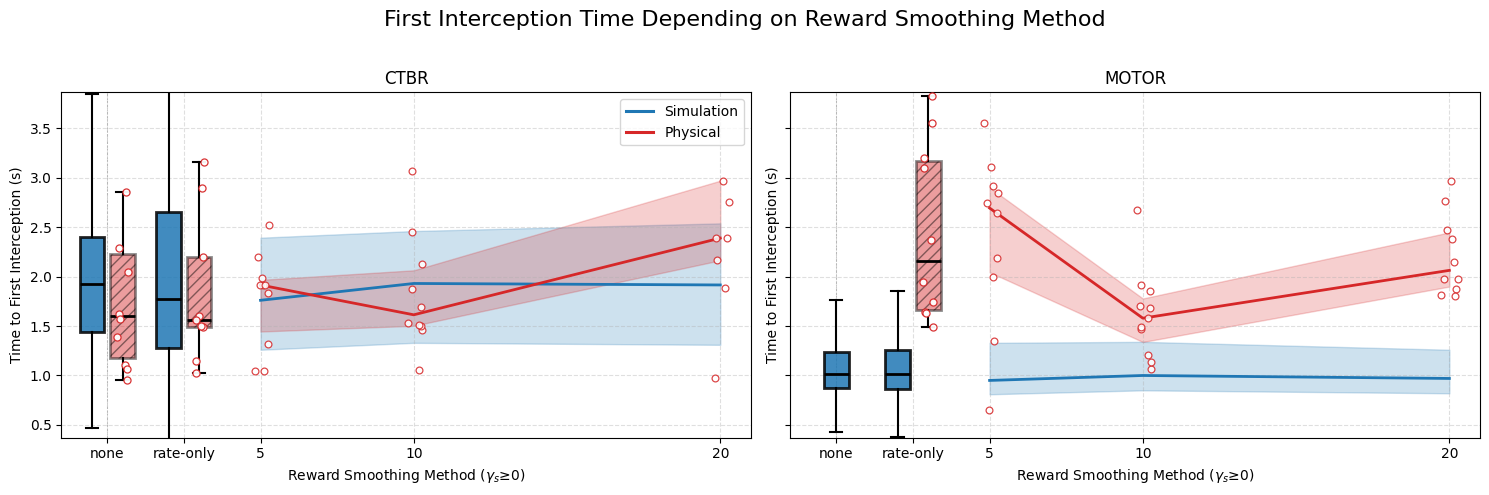

💾 saved: /Users/merlijnbroekers/Desktop/Drone_Interception/figures/reward_smoothing/overlay_tinm_vs_gamma_IQR.png


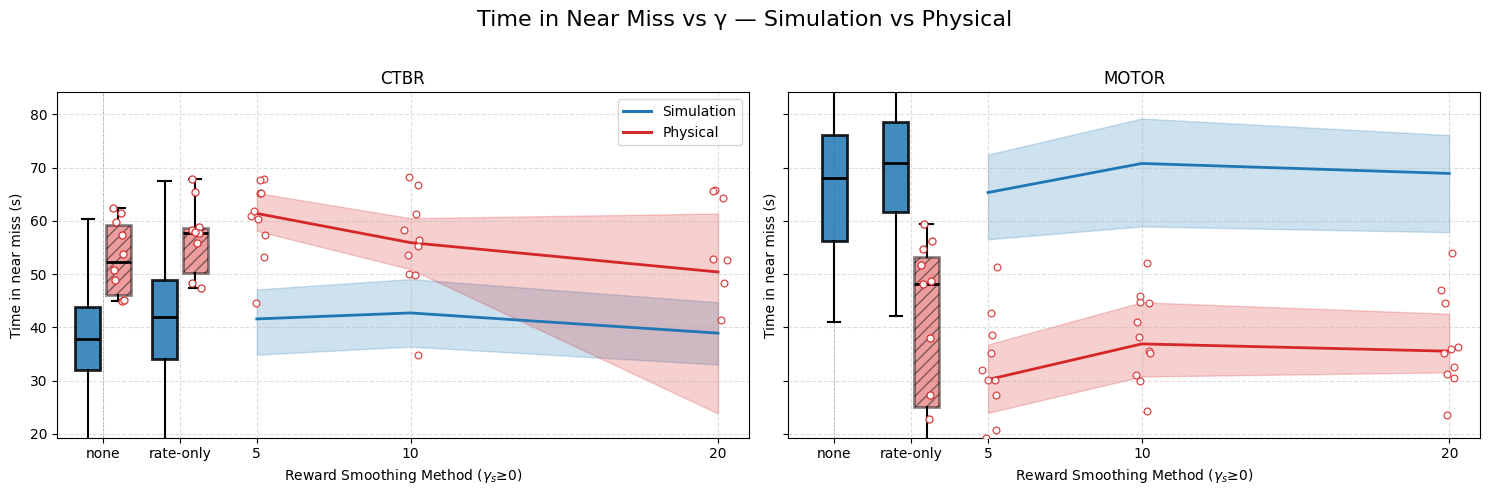

In [13]:
from scripts.analysis.utils.plot_utils import plot_sim_real_gamma_with_baselines_IQR


# - SIM_DATA: from simulation sweep 
# reward_smoothing_moth_results.pkl --> for all gamma 
# reward_smoothing_moth_results_2.pkl --> for gamma also tested in real life
SIM_DATA  = Path(f"{project_root}/analysis_out/trials/reward_smoothing_2.pkl")

# - REAL_DATA: from your real-life processing (real_metrics_reward_smoothing.csv)
project_root = "/Users/merlijnbroekers/Desktop/Drone_Interception"
REAL_DATA = Path(f"{project_root}/real_metrics_reward_smoothing.csv")  # adjust if you saved elsewhere

print("Sim pkl exists? ", SIM_DATA.exists())
print("Real CSV exists?", REAL_DATA.exists())

KIND_LABELS = {"gamma": "Gamma smoothing", "none": "No smoothing", "rate_only": "Rate-only"}
SIM_COLOR   = "#1f77b4"
REAL_COLOR  = "#d62728"

ABS_ORDER   = {"ctbr": 0, "motor": 1, "CTBR": 0, "MOTOR": 1}
ABS_MAP_UP  = {"ctbr": "CTBR", "motor": "MOTOR"}  # normalize names

def _norm_levels(df_sim, df_real):
    """Make a common 'level_label' column ('CTBR'/'MOTOR') in both dataframes."""
    s = df_sim.copy()
    r = df_real.copy()
    # sim uses 'abstraction' -> normalize
    if "abstraction" in s.columns:
        s["level_label"] = s["abstraction"].map(lambda a: ABS_MAP_UP.get(str(a).lower(), str(a).upper()))
    # real already has 'level_label' in the script we built
    if "level_label" not in r.columns and "level_key" in r.columns:
        r["level_label"] = r["level_key"].map(lambda a: ABS_MAP_UP.get(str(a).lower(), str(a).upper()))
    return s, r

# LOAD DATA
with open(SIM_DATA, "rb") as f:
    sim_df = pickle.load(f)
real_df = pd.read_csv(REAL_DATA)

# SWITCH TO A SHARED 'level_label'
sim_df, real_df = _norm_levels(sim_df, real_df)

plot_sim_real_gamma_with_baselines_IQR(
    sim_df=sim_df,
    real_df=real_df,
    ycol="first_interception_time",
    title="First Interception Time Depending on Reward Smoothing Method",
    ylabel="Time to First Interception (s)",
    out_png=f"{project_root}/figures/reward_smoothing/overlay_fit_vs_gamma_IQR.png",
    successes_only=True,
    show_real_samples=True,
)

plot_sim_real_gamma_with_baselines_IQR(
    sim_df=sim_df,
    real_df=real_df,
    ycol="time_in_near_miss",
    title="Time in Near Miss vs γ — Simulation vs Physical",
    ylabel="Time in near miss (s)",
    out_png=f"{project_root}/figures/reward_smoothing/overlay_tinm_vs_gamma_IQR.png",
    successes_only=False,
    show_real_samples=True,
)

